In [5]:
import json
import numpy as np
import pandas as pd

from sncosmo.bandpasses import _BANDPASSES
from astropy.time import Time
import glob

import matplotlib.pyplot as plt
import seaborn as sns


def loadEvent(filename):
    """
    Reads in lightcurve data from a file and returns data in a dictionary format.
    
    Args:
    - filename (str): Path to lightcurve file
    
    Returns:
    - data (dict): Dictionary containing the lightcurve data from the file. The keys are generally 't' and each of the filters in the file as well as their accompanying error values.
    """
    if filename.endswith(".json"):
        with open(filename) as f:
            data = json.load(f)
            for key in data.keys():
                data[key] = np.array(data[key])
    else:
        lines = [line.rstrip("\n") for line in open(filename)]
        lines = filter(None, lines)

        sncosmo_filts = [val["name"] for val in _BANDPASSES.get_loaders_metadata()]
        sncosmo_maps = {name: name.replace(":", "_") for name in sncosmo_filts}

        data = {}
        for line in lines:
            lineSplit = line.split(" ")
            lineSplit = list(filter(None, lineSplit))
            mjd = Time(lineSplit[0], format="isot").mjd
            filt = lineSplit[1]

            if filt in sncosmo_maps:
                filt = sncosmo_maps[filt]

            mag = float(lineSplit[2])
            dmag = float(lineSplit[3])

            if filt not in data:
                data[filt] = np.empty((0, 3), float)
            data[filt] = np.append(data[filt], np.array([[mjd, mag, dmag]]), axis=0)

    return data

def read_lightcurve_file(filename: str) -> dict:
    """
    Function to read in lightcurve file and create a dictionary containing the time (in days) at which the lightcurves 
    are evaluated and the corresponding values for different filters.
    """

    with open(filename, "r") as f:
        header = list(filter(None, f.readline().rstrip().strip("#").split(" ")))
    df = pd.read_csv(
        filename,
        delimiter=" ",
        comment="#",
        header=None,
        names=header,
        index_col=False,
    )
    df.rename(columns={"t[days]": "t"}, inplace=True)

    return df#.to_dict(orient="series")


bulla_grid_files = sorted(glob.glob("lcs_bulla_2022/*.dat"))
read_lightcurve_file(bulla_grid_files[0]).describe()

,t,bessellux,bessellb,bessellv,bessellr,besselli,sdssu,ps1::g,ps1::r,ps1::i,...,uvot::v,uvot::white,atlasc,atlaso,2massj,2massh,2massks,ztfg,ztfr,ztfi
count,100.000000,84.00000,92.00000,93.000,98.00000,99.0000,98.00000,96.00000,93.000,97.000,...,92.00000,96.000,92.00000,97.000,98.00000,100.00000,100.00000,96.00000,93.000,98.00000
mean,5.500050,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
std,7.615685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.103000,-16.34600,-16.18900,-16.194,-15.78000,-15.8210,-16.35900,-16.22500,-15.991,-15.907,...,-16.33300,-16.682,-16.04100,-15.667,-14.96900,-15.34400,-14.38900,-16.23000,-15.816,-15.70800
25%,0.428750,-15.35050,-14.98150,-14.864,-14.71000,-14.5825,-14.97900,-14.86025,-14.724,-14.647,...,-14.89175,-14.722,-14.85200,-14.681,-14.42075,-14.27925,-14.05275,-14.86325,-14.706,-14.60250
50%,1.784500,-12.25750,-12.87050,-13.879,-14.15500,-14.3560,-10.82650,-13.40100,-14.166,-14.344,...,-13.85200,-11.939,-13.78300,-14.238,-14.06050,-13.96200,-13.57650,-13.34950,-14.179,-14.35750
75%,7.424500,-4.01975,-4.58425,-6.996,-7.13625,-8.8445,-0.82175,-4.59300,-8.075,-8.953,...,-7.39050,-3.867,-6.93475,-8.171,-11.61725,-12.01775,-12.02000,-4.35725,-8.944,-9.01525
max,30.890000,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [4]:
bulla_grid_lightcurves = {filename: read_lightcurve_file(filename) for filename in list(bulla_grid_files)}

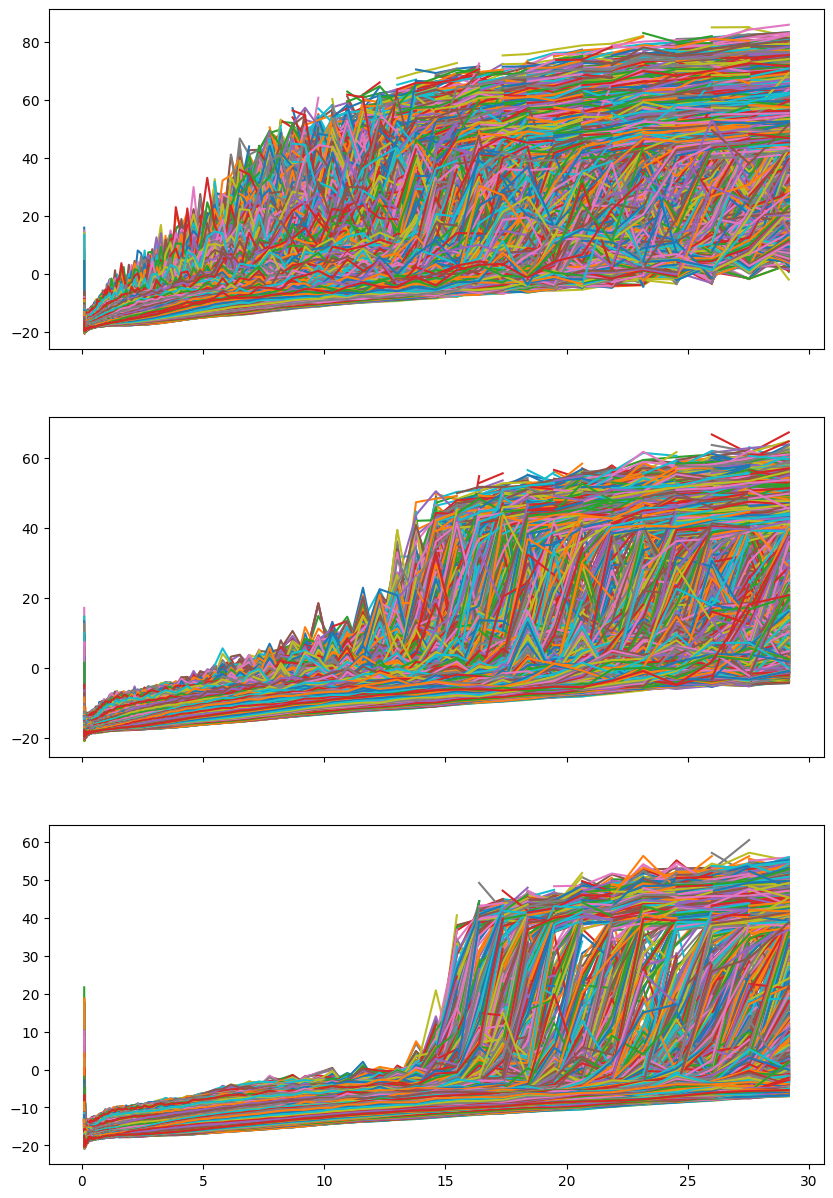

In [7]:
## plot all of the lightcurves in a 3x1 grid where each subplot corresponds to ztfg, ztfr, and ztfi filters
fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
for key, value in bulla_grid_lightcurves.items():
    ax[0].errorbar(value["t"], value["ztfg"])
    ax[1].errorbar(value["t"], value["ztfr"])
    ax[2].errorbar(value["t"], value["ztfi"])

In [2]:
def fwhm(lightcurve, filter):
    '''
    Function to calculate the duration the lightcurve is brighter than the half maximum value. Here, lightcurves are in magnitudes, so the "maximum" is the most negative value. less negative values are dimmer than more negative values.
    
    Args:
    - lightcurve (string): path to lightcurve. Read in by read_lightcurve_file (NMMA Note: using pandas here, will have to later adapt to using the dict as is standard for the NMMA version of function)
    - filter (string, list): filter(s) to calculate FWHM for. If multiple filters are provided in a list, the function will return each filter's FWHM as a dictionary.
    
    Returns:
    - FWHM (float, dict): dictionary where each key corresponds to a filter and each value is a tuple containing the maximum magnitude in the first index and the duration it is brighter than half maximum in the second index.
    
    TODO: make more resilient to positive magnitudes, switch to using dict as input
    '''
    
    ## read in lightcurve
    lc = read_lightcurve_file(lightcurve)
    
    ## if filter is a string, convert to list
    if isinstance(filter, str):
        filter = [filter]
    
    ## ensure all filters are in the lightcurve 
    for f in filter:
        if f not in lc.columns:
            raise ValueError(f"Filter {f} not in lightcurve. Available filters are {lc.columns.pop('t')}")
    
    ## calculate the maximum magnitude for each filter and then calculate the duration it is brighter than half the maximum
    FWHM = {}
    for f in filter:
        max_mag = lc[f].min()
        bright = lc[lc[f] < max_mag/2]
        duration = bright["t"].max() - bright["t"].min()
        FWHM[f] = (max_mag, duration)
    return FWHM


In [3]:
fwhm(bulla_grid_files[0], "ztfg")

{'ztfg': (-16.23, 4.009)}

In [4]:


# Initialize an empty list to store the results
df_list = []
filters = ['ztfg', 'ztfr', 'ztfi']
# Loop through the files
for f in bulla_grid_files:
    # Loop through the filters
    for filt in filters:
        # Calculate the FWHM
        fwhm_value = fwhm(f, filt)
        # Create a temporary DataFrame and append it to the list
        df_temp = pd.DataFrame({'file': [f], 'filter': [filt], 'peak_magnitude': [fwhm_value[filt][0]], 'fwhm': [fwhm_value[filt][1]]})
        df_list.append(df_temp)

# Concatenate all the dataframes in the list
df_fwhm = pd.concat(df_list, ignore_index=True)

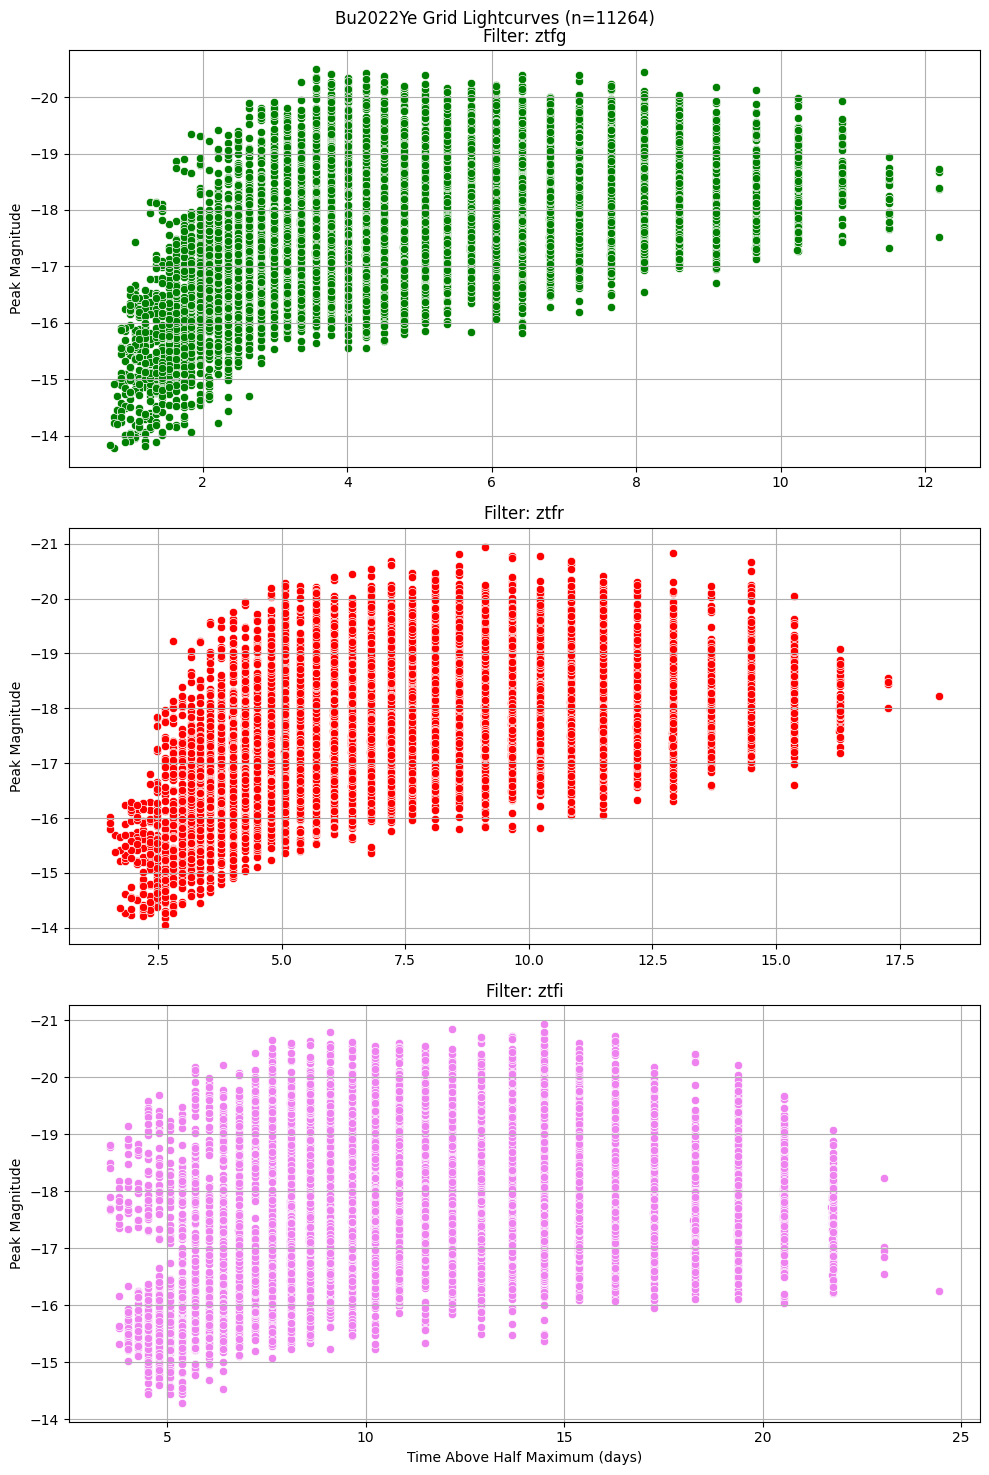

In [5]:
# Create a 3 subplot figure
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
colors = ['green', 'red', 'violet']
# Loop through the filters and plot the data
for i, filter in enumerate(['ztfg', 'ztfr', 'ztfi']):
    axs[i].grid()
    df_filter = df_fwhm[df_fwhm['filter'] == filter]
    sns.scatterplot(data=df_filter, x='fwhm', y='peak_magnitude', ax=axs[i], color=colors[i]).set_title(f'Filter: {filter}')
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Time Above Half Maximum (days)') if i == 2 else axs[i].set_xlabel('')
    axs[i].set_ylabel('Peak Magnitude')
    

plt.suptitle(f'Bu2022Ye Grid Lightcurves (n={len(bulla_grid_files)})')
plt.tight_layout()
plt.show()